# Algorithms Comparison & Evaluation
## Table of Contents 
1. Chapter Outline
2. Introduction
3. Read in the data
4. Calculate Performance
5. Evaluate Performance
6. Conculsion

In [32]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

# import standard libs
from pathlib import Path
import sys
import time
import os
from copy import copy
import json


data_dir = "../data"
script_dir =  "../scripts"
sys.path.append(script_dir)

# import python scientific stack
import pandas as pd

pd.options.display.float_format = "{:,.4f}".format
import pandas_datareader as pdr
import numpy as np

# import monthly_returns_heatmap as mrh
import math

import ffn
import pyfolio as pf
import quantstats as qs

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline
savefig_kwds = dict(dpi=300, bbox_inches="tight")

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from utils import *

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-08-08T16:47:04.472890+02:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas           : 1.5.3
pandas_datareader: 0.10.0
numpy            : 1.23.5
sklearn          : 1.2.2
statsmodels      : 0.14.0
scipy            : 1.10.1
matplotlib       : 3.7.1
seaborn          : 0.12.2



<IPython.core.display.Javascript object>

In [33]:
%load_ext nb_black

sns_params = {
    "xtick.major.size": 1,
    "ytick.major.size": 1,
    "font.size": 10,
    "font.weight": "medium",
    "figure.figsize": (12, 10),
    "font.family": "DeJavu Serif",
}

sns.set_style("white", sns_params)
sns.set_context(sns_params)
savefig_kwds = dict(dpi=150, bbox_inches="tight", frameon=True, format="png")
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#f4cae4"]
sns.set_palette(sns.color_palette(flatui, 7))


def save_image(fig, fn):
    fig.savefig(Path("../visuals" / f"{fn}.png").as_posix(), **savefig_kwds)
    print(f"image saved: {fn}")
    return

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Introduction

Test of an gmm inverse VAR portfolio allocation algorithm verse some common benchmarks. 

The symbol universe consisted of the following ETFs:

_"SPY", "QQQ", "DIA", "TLT", "GLD", "EFA", "EEM", 'BND', 'VNQ'_

- All the algorithms start from `2008-01-01` and run until `2023-07-31`.
- We Rebalance monthly.
- Target weights had a 5% corridor or +/- 2.5% (to minimize transaction costs). 

The benchmark algorithms are the equal weight and 60/40 SPY/BND algorithm. 

I tested 2 Historical VAR models. 
One with a lookback of 252 days and the other with a lookback 60 days. 

I tested 2 GMM VAR models.
One with a lookback of 252 days and the other 60 days. 
I restricted the model to 2 components.

## Read in the data

In [34]:
def read_bt_json(fp):
    """fn: read Quantconnect backtest json"""
    with open(fp, encoding="utf-8") as f_in:
        return json.load(f_in)


def extract_portfolio_equity(jdata):
    """fn: extract port equity timeseries from Quantconnect json"""
    d = jdata["Charts"]["Strategy Equity"]["Series"]["Equity"]["Values"]
    equity = (
        pd.DataFrame(d)
        .rename(columns=dict(x="time", y="equity"))
        .assign(time=lambda df: pd.to_datetime(df.time, utc=True, unit="s"))
        .set_index("time")
    )
    return equity


def _get_column_name(text):
    """fn: to get column name as first text group"""
    # n = 4 # hardcoded based on fn structure
    groups = text.split(".")
    return "_".join(groups[:-1])


def read_port_equity(dir_, fn):
    fp = Path(dir_ / fn)  # .as_posix()
    jdata = read_bt_json(fp)

    # get column name
    col = _get_column_name(fn)
    # extract equity data
    equity = extract_portfolio_equity(jdata).rename(columns=dict(equity=col))
    return equity

<IPython.core.display.Javascript object>

In [35]:
filenames = [
    "equal_weight_benchmark_[2023-07]",
    "60_40_benchmark_[2023-07]",
    "gmm_60_[2023-07]",
    "gmm_252_[2023-07]",
    "historical_60_[2023-07]",
    "historical_252_[2023-07]",
]

dfs = [read_port_equity(Path("../backtests"), f"{fn}.json") for fn in filenames]
df = pd.concat(dfs, axis=1).sort_index().dropna().drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5828 entries, 2008-01-01 05:00:00+00:00 to 2023-07-31 20:00:00+00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   equal_weight_benchmark_[2023-07]  5828 non-null   float64
 1   60_40_benchmark_[2023-07]         5828 non-null   float64
 2   gmm_60_[2023-07]                  5828 non-null   float64
 3   gmm_252_[2023-07]                 5828 non-null   float64
 4   historical_60_[2023-07]           5828 non-null   float64
 5   historical_252_[2023-07]          5828 non-null   float64
dtypes: float64(6)
memory usage: 318.7 KB


<IPython.core.display.Javascript object>

## Calculate Performance

In [36]:
def to_price_index(df, start=1):
    return start * (np.exp(df.cumsum()))


def common_sense_ratio(returns):
    # common sense ratio
    ratio = (abs(returns.quantile(0.95)) * returns[returns > 0].sum()) / abs(
        abs(returns.quantile(0.05)) * returns[returns < 0].sum()
    )
    ratio = round(ratio, 2)
    return ratio


def plot_pf(returns):
    plots = [
        pf.plot_rolling_returns,
        pf.plot_annual_returns,
        pf.plot_monthly_returns_heatmap,
        pf.plot_monthly_returns_dist,
        pf.plot_drawdown_underwater,
    ]

    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1.0, 1, 1])

    for i, func in enumerate(plots):

        if i == 0:
            ax = plt.subplot(gs[0, :])
            func(returns, ax=ax)
        elif i < 4:
            ax = plt.subplot(gs[1, i - 1])
            func(returns, ax=ax)
        elif i == 4:
            ax = plt.subplot(gs[2, :])
            func(returns, ax=ax)
        else:
            continue

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [37]:
# keep_stats = test.index[0:7].tolist() + test.index[16:].tolist()
keep_stats = [
    "start",
    "end",
    "rf",
    "total_return",
    "cagr",
    "max_drawdown",
    "calmar",
    "daily_sharpe",
    "daily_sortino",
    "daily_mean",
    "daily_vol",
    "daily_skew",
    "daily_kurt",
    "best_day",
    "worst_day",
    "monthly_sharpe",
    "monthly_sortino",
    "monthly_mean",
    "monthly_vol",
    "monthly_skew",
    "monthly_kurt",
    "best_month",
    "worst_month",
    "yearly_sharpe",
    "yearly_sortino",
    "yearly_mean",
    "yearly_vol",
    "yearly_skew",
    "yearly_kurt",
    "best_year",
    "worst_year",
    "avg_drawdown",
    "avg_drawdown_days",
    "avg_up_month",
    "avg_down_month",
    "win_year_perc",
    "twelve_month_win_perc",
]


def view_strats(strats):
    return ffn.calc_stats(strats).stats.loc[keep_stats]


strats = pd.DataFrame()

# plot helper for labeling scatter plot
def label_point(x, y, val, ax, rotation=10, ha="center", va="baseline"):
    """
    label points on a scatter plot

    See:
        https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
    :param x: pd.Series
    :param y: pd.Series
    :param val: pd.Series
    :param ax: matplotlib axis
    :return:
    """
    a = pd.concat({"x": x, "y": y, "val": val}, axis=1).dropna()
    for i, point in a.iterrows():
        ax.text(
            point["x"],
            point["y"],
            str(point["val"]),
            rotation=rotation,
            horizontalalignment=ha,
            verticalalignment=va,
        )

<IPython.core.display.Javascript object>

In [38]:
"""def calc_stats(returns, bm):
    stats = [f for f in dir(qs.stats) if f[0] != "_"]

    agg_stats = {}
    for stat_func in stats:
        try:
            agg_stats[stat_func] = pd.eval(f"qs.stats.{stat_func}")(returns)
        except:
            try:
                agg_stats[stat_func] = pd.eval(f"qs.stats.{stat_func}")(returns, bm)
            except Exception as e:
                print(e)
                continue

    return pd.DataFrame.from_dict(agg_stats, orient="index")"""

'def calc_stats(returns, bm):\n    stats = [f for f in dir(qs.stats) if f[0] != "_"]\n\n    agg_stats = {}\n    for stat_func in stats:\n        try:\n            agg_stats[stat_func] = pd.eval(f"qs.stats.{stat_func}")(returns)\n        except:\n            try:\n                agg_stats[stat_func] = pd.eval(f"qs.stats.{stat_func}")(returns, bm)\n            except Exception as e:\n                print(e)\n                continue\n\n    return pd.DataFrame.from_dict(agg_stats, orient="index")'

<IPython.core.display.Javascript object>

In [39]:
# strategy returns

for col in df.columns:
    strats[col] = np.log(df[col] / df[col].shift(1))
strats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5828 entries, 2008-01-01 05:00:00+00:00 to 2023-07-31 20:00:00+00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   equal_weight_benchmark_[2023-07]  5827 non-null   float64
 1   60_40_benchmark_[2023-07]         5827 non-null   float64
 2   gmm_60_[2023-07]                  5827 non-null   float64
 3   gmm_252_[2023-07]                 5827 non-null   float64
 4   historical_60_[2023-07]           5827 non-null   float64
 5   historical_252_[2023-07]          5827 non-null   float64
dtypes: float64(6)
memory usage: 318.7 KB


<IPython.core.display.Javascript object>

In [40]:
strats

,equal_weight_benchmark_[2023-07],60_40_benchmark_[2023-07],gmm_60_[2023-07],gmm_252_[2023-07],historical_60_[2023-07],historical_252_[2023-07]
time,,,,,,
2008-01-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02 15:09:00+00:00,-0.0017,-0.0029,-0.0005,-0.0006,-0.0002,-0.0003
2008-01-03 05:00:00+00:00,-0.0043,-0.0038,-0.0005,-0.0006,0.0002,0.0001
2008-01-04 05:00:00+00:00,-0.0020,-0.0005,-0.0011,-0.0013,-0.0005,-0.0008
2008-01-04 14:31:00+00:00,-0.0052,-0.0030,-0.0028,-0.0030,-0.0017,-0.0017
...,...,...,...,...,...,...
2023-07-28 04:00:00+00:00,-0.0107,-0.0074,-0.0144,-0.0154,-0.0098,-0.0102
2023-07-28 13:31:00+00:00,0.0071,0.0008,0.0093,0.0092,0.0058,0.0061
2023-07-29 04:00:00+00:00,0.0007,0.0006,0.0014,0.0014,0.0008,0.0011


<IPython.core.display.Javascript object>

In [41]:
# create strategy result df which holds all the computed metrics
strat_res = pd.concat(
    [view_strats(df[col].dropna()).rename(col) for col in strats.columns], axis=1
)

# add common sense ratios
common_sense_ratios = pd.Series(
    [common_sense_ratio(strats[col].dropna()) for col in strats.columns],
    index=strats.columns,
)

strat_res.loc["common_sense_ratio"] = common_sense_ratios

# add avg of worst 5 drawdown durations in days
avg_worst_5_drawdowns_duration = pd.Series(
    [
        pf.timeseries.gen_drawdown_table(strats[col].dropna()).Duration.iloc[:5].mean()
        for col in strats.columns
    ],
    index=strats.columns,
)
strat_res.loc["avg_worst_5_drawdown_duration"] = avg_worst_5_drawdowns_duration

# add avg of worst 5 drawdowns (%)
avg_worst_5_drawdowns = pd.Series(
    [
        pf.timeseries.gen_drawdown_table(strats[col].dropna())["Net drawdown in %"]
        .iloc[:5]
        .mean()
        * -0.01
        for col in strats.columns
    ],
    index=strats.columns,
)

strat_res.loc["avg_worst_5_drawdowns"] = avg_worst_5_drawdowns

<IPython.core.display.Javascript object>

In [42]:
strats.columns

Index(['equal_weight_benchmark_[2023-07]', '60_40_benchmark_[2023-07]',
       'gmm_60_[2023-07]', 'gmm_252_[2023-07]', 'historical_60_[2023-07]',
       'historical_252_[2023-07]'],
      dtype='object')

<IPython.core.display.Javascript object>

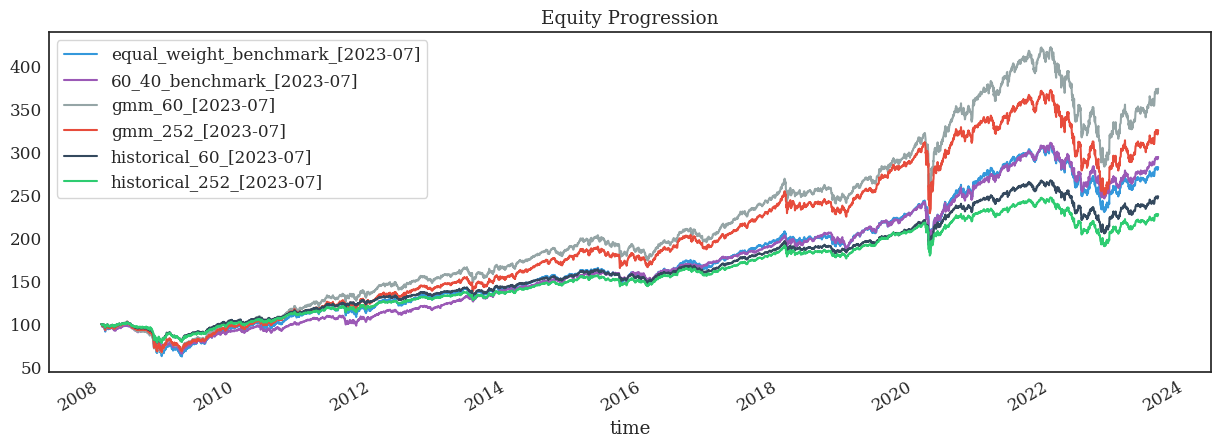

<IPython.core.display.Javascript object>

In [43]:
perf = ffn.calc_stats(df)
perf.plot()
plt.savefig("../visuals/04/equity_progression")

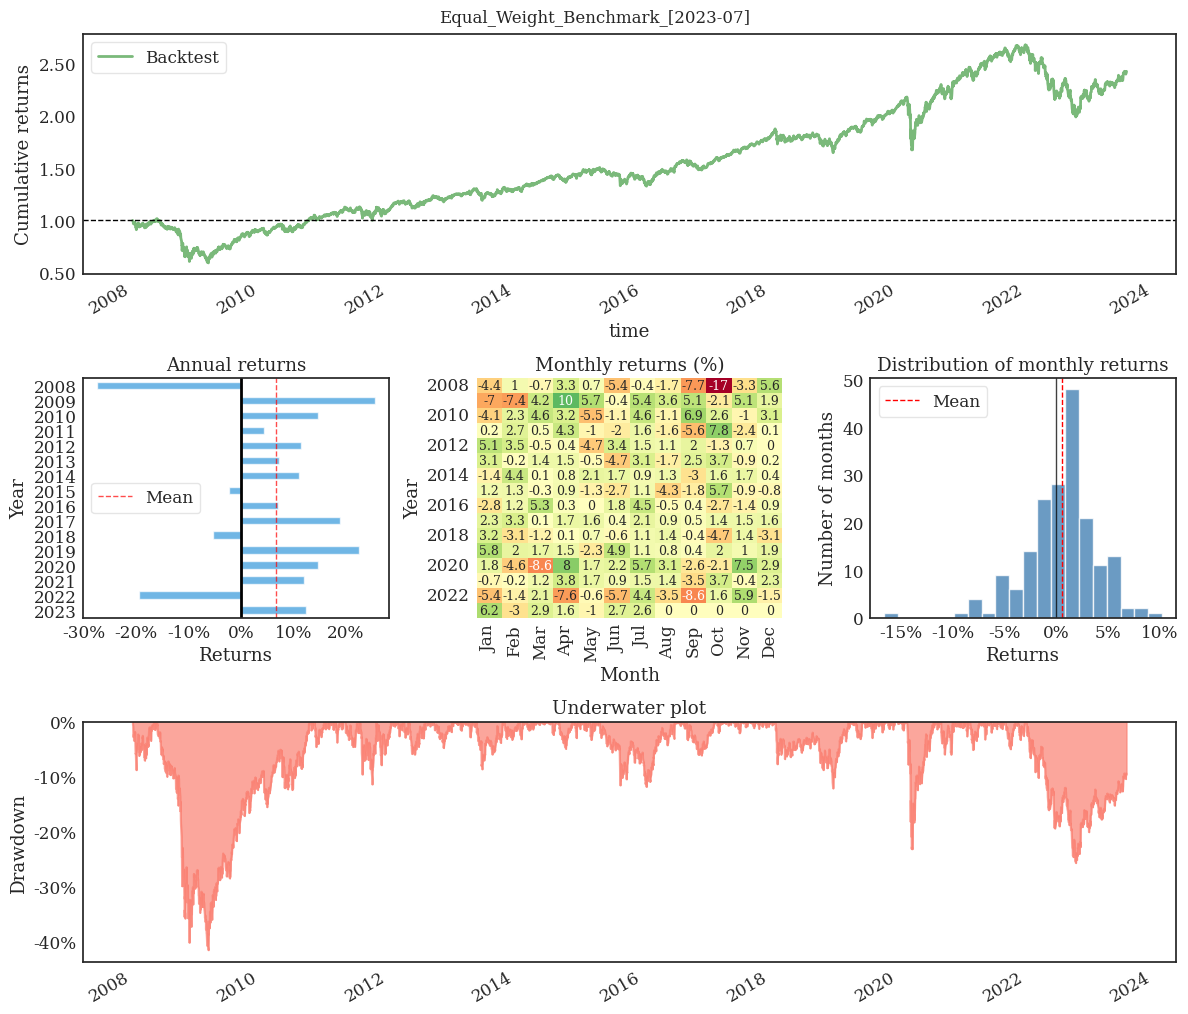

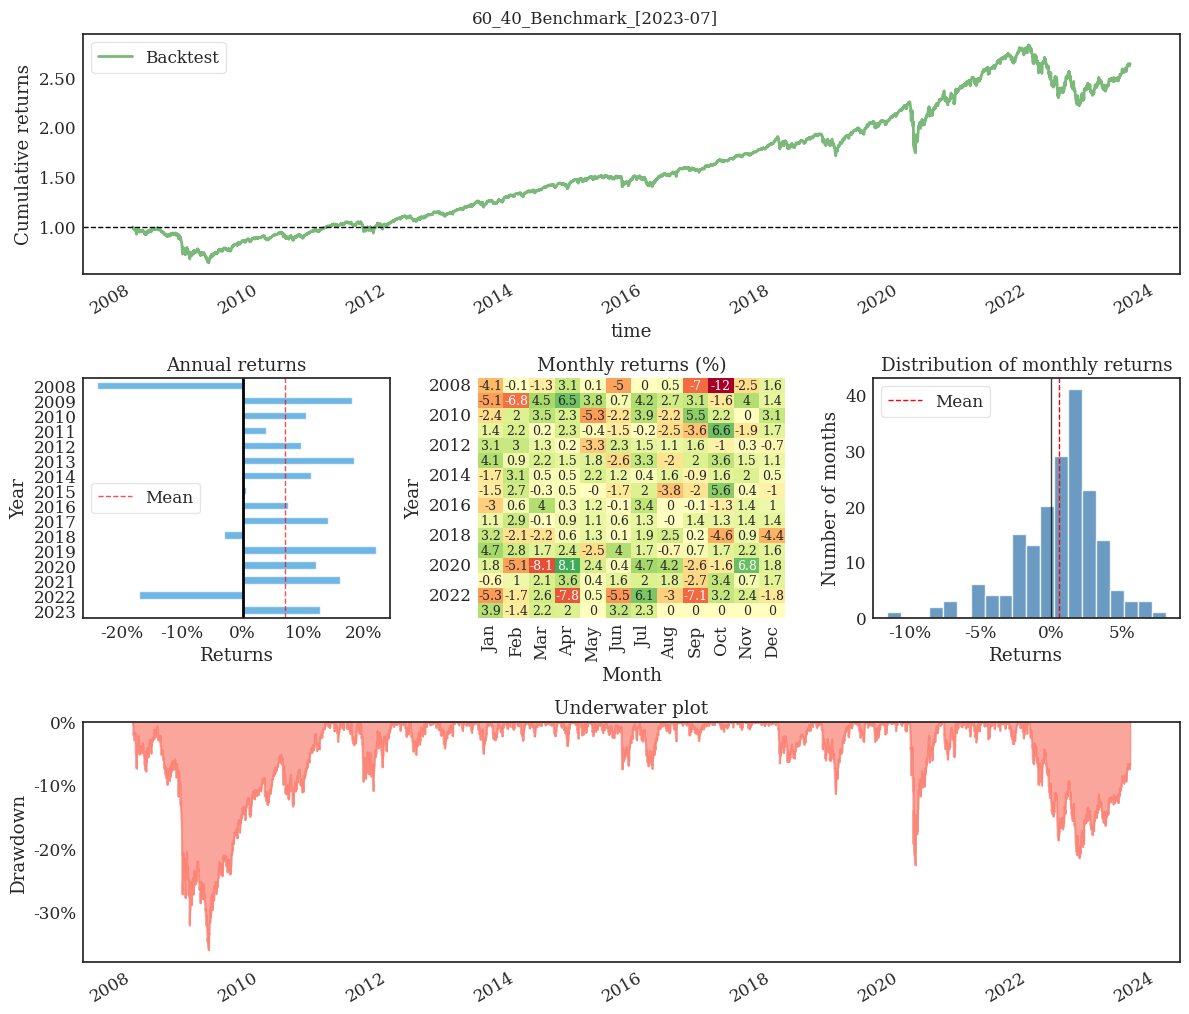

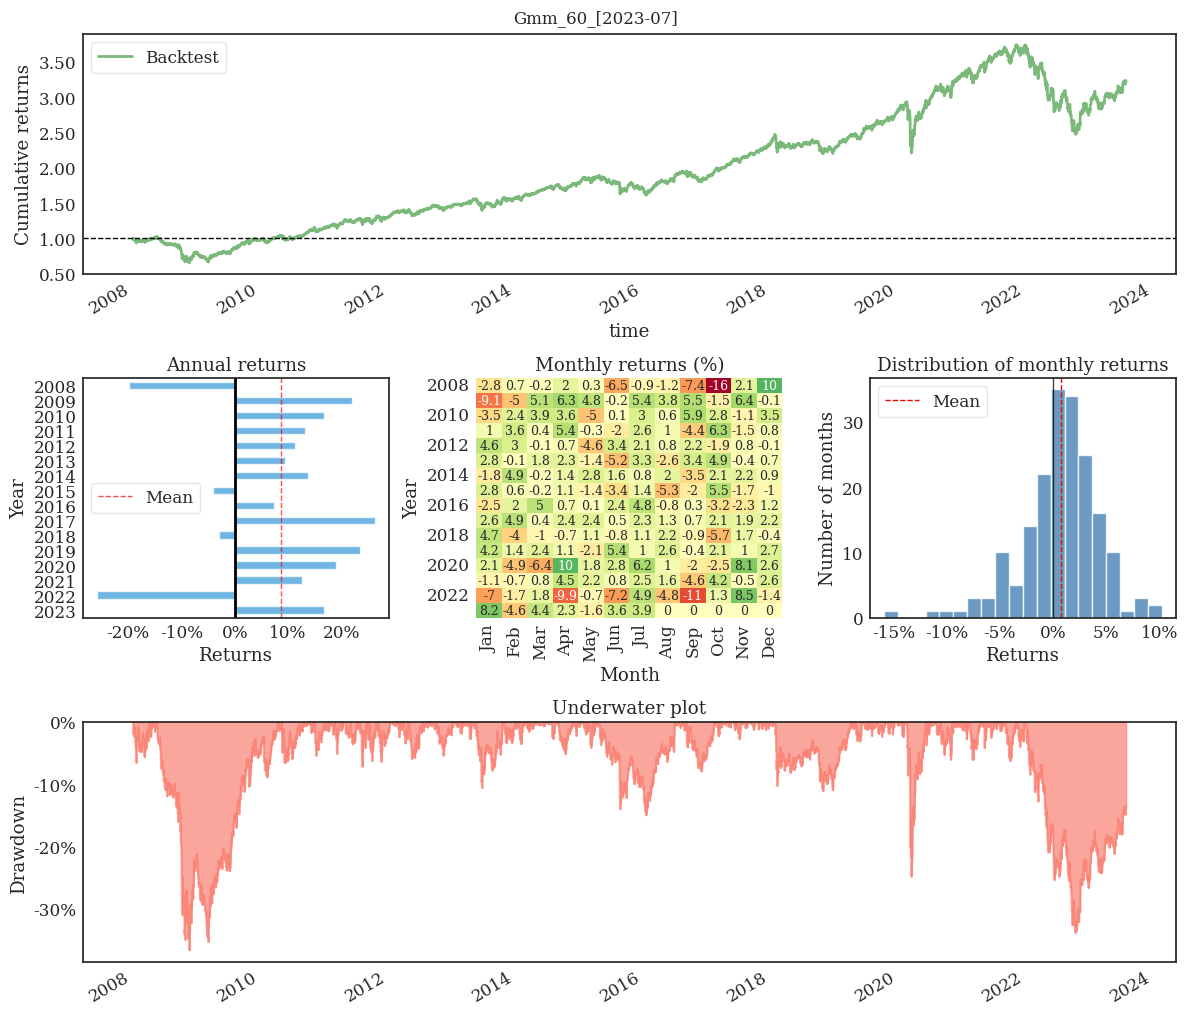

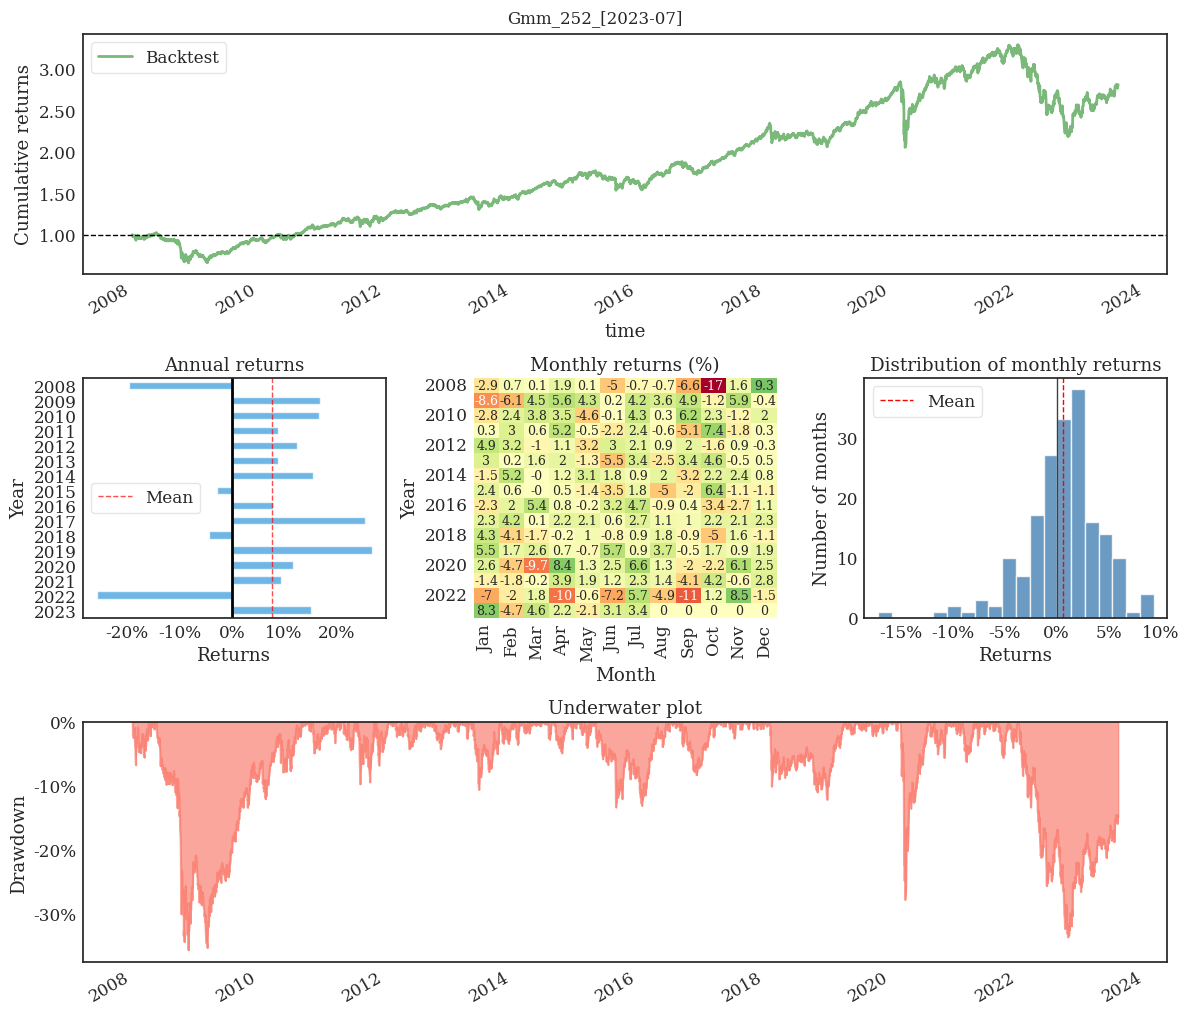

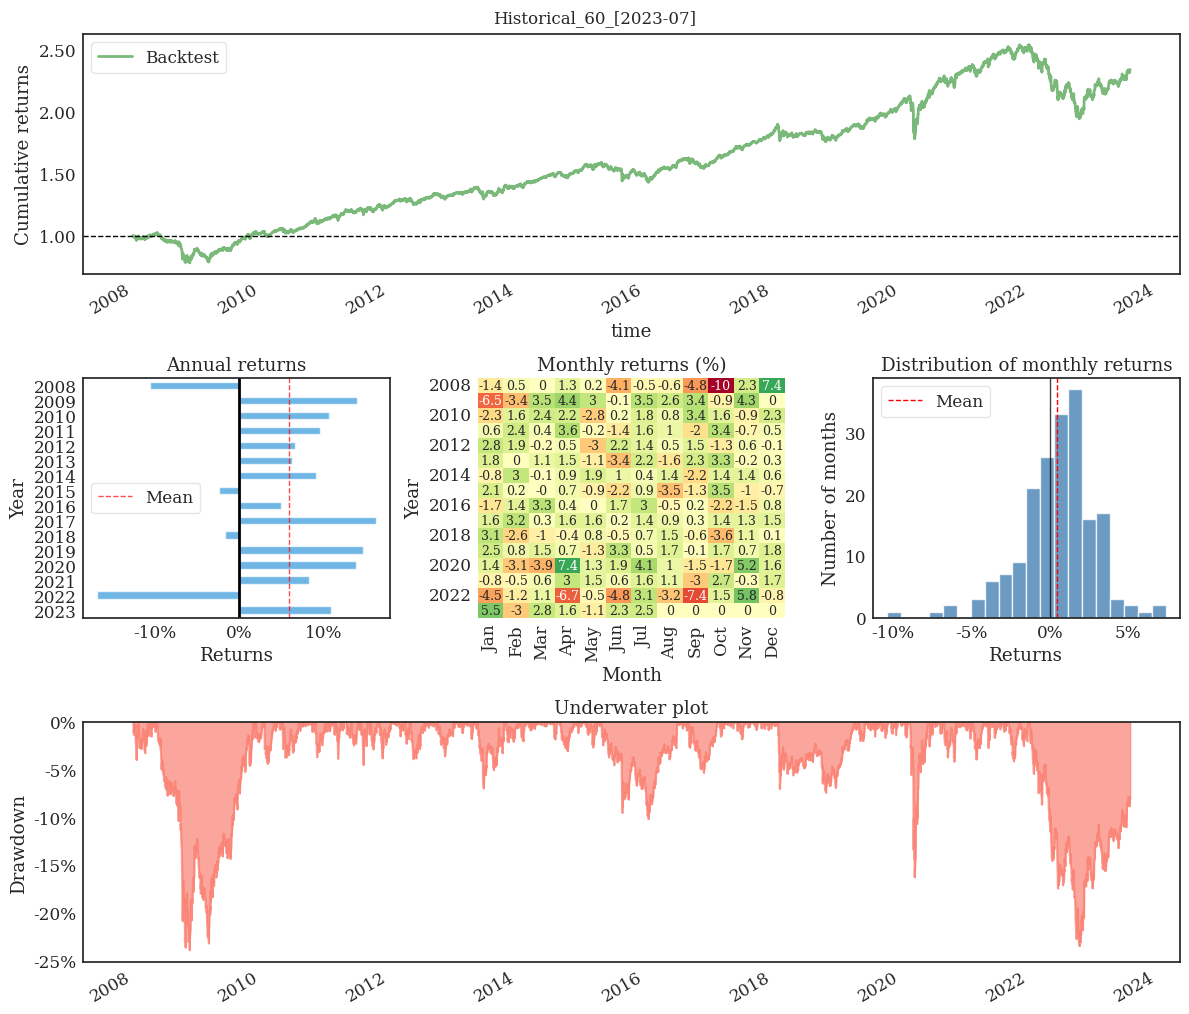

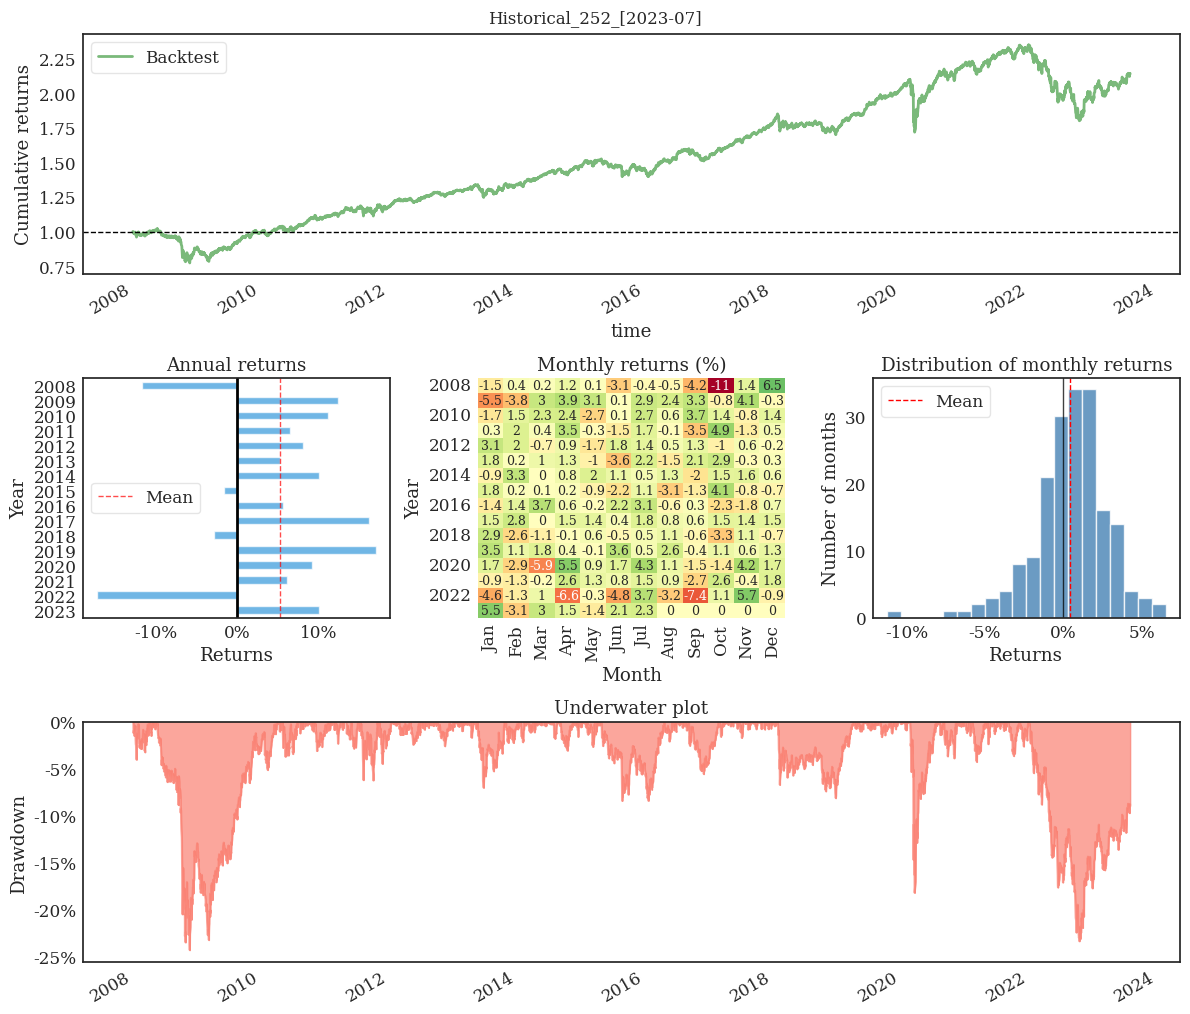

<IPython.core.display.Javascript object>

In [44]:
for col in strats.columns:
    plot_pf(strats[col])
    plt.suptitle(col.title(), y=1.01)
    plt.savefig("../visuals/04/performance_plots/"+col)

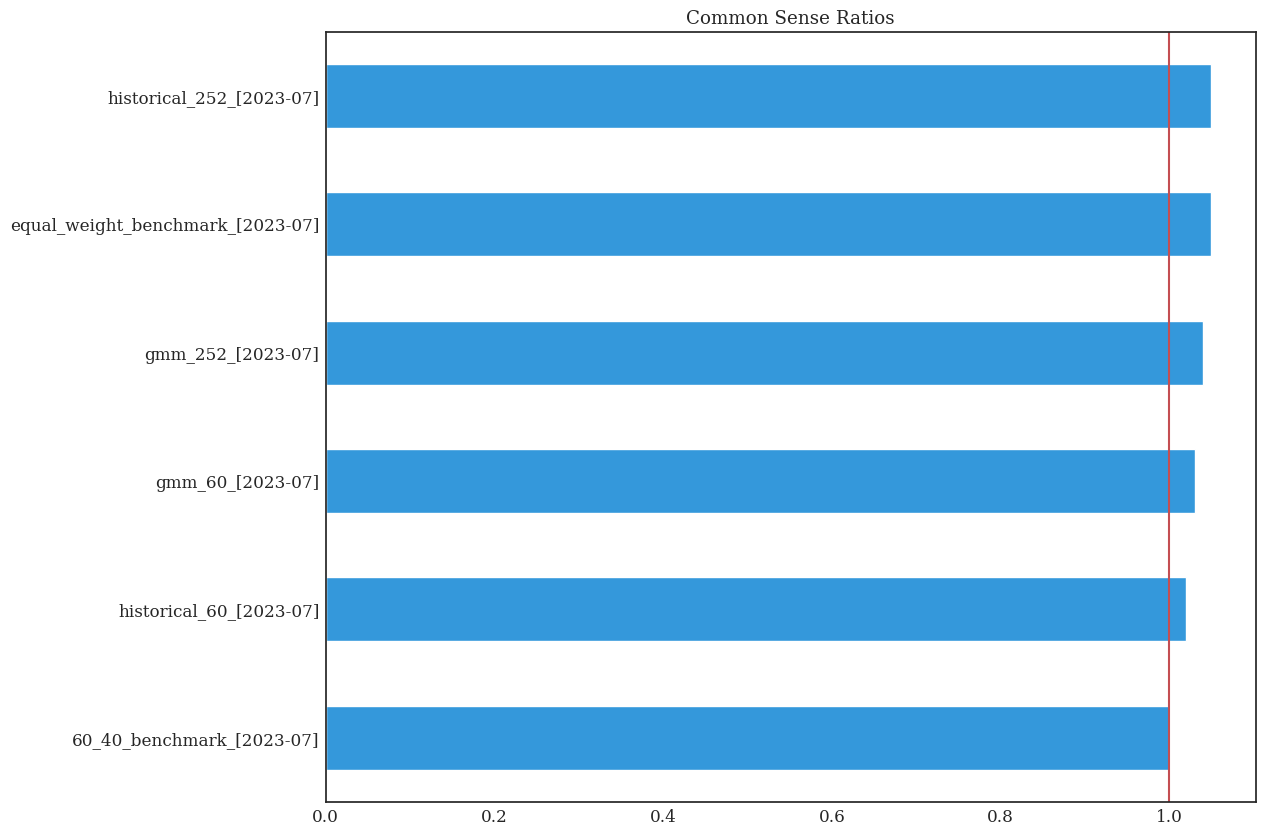

<IPython.core.display.Javascript object>

In [45]:
ax = (
    strat_res.loc["common_sense_ratio"]
    .sort_values()
    .plot.barh(title="Common Sense Ratios")
)

plt.axvline(1.0, color="r")

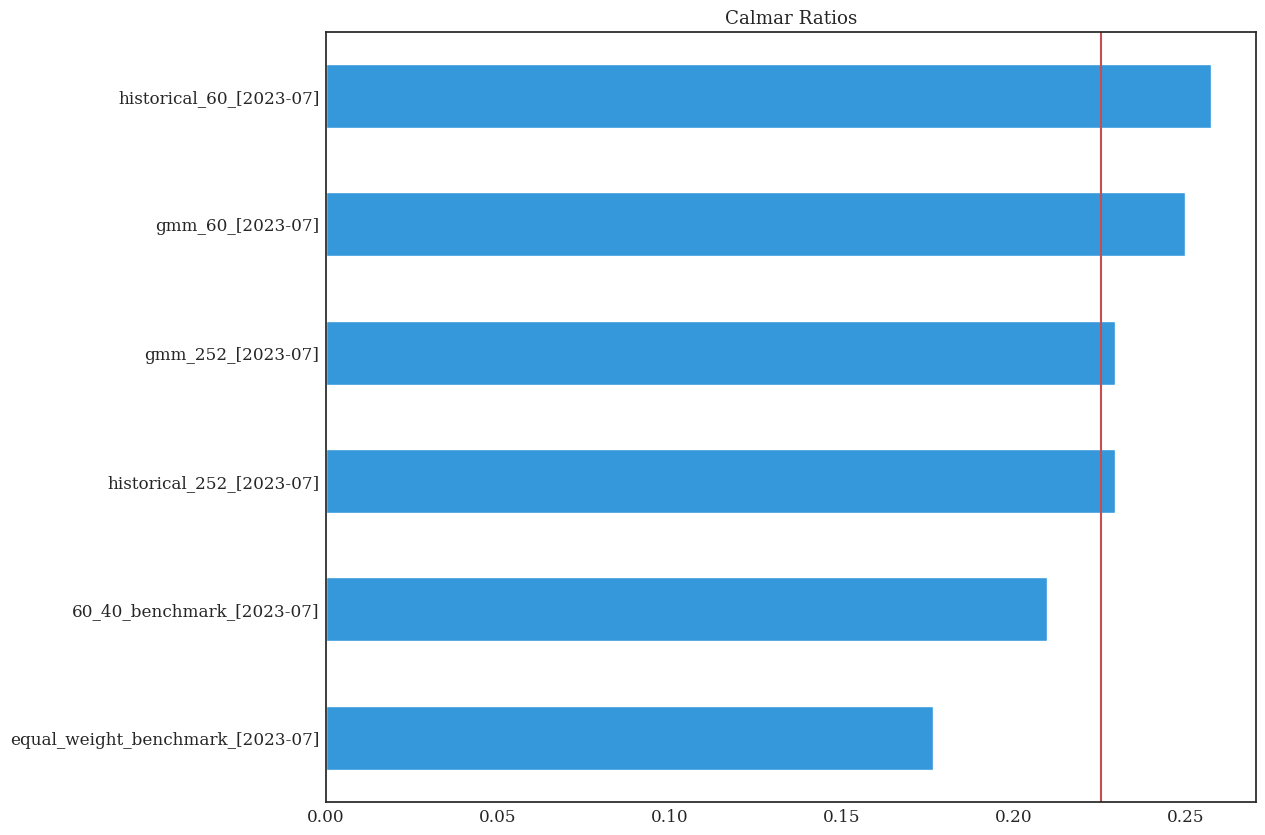

<IPython.core.display.Javascript object>

In [46]:
ax = strat_res.loc["calmar"].sort_values().plot.barh(title="Calmar Ratios")
plt.xlim(0)
plt.axvline(strat_res.loc["calmar"].mean(), color="r")
#add_watermark(ax, scale=1.25)

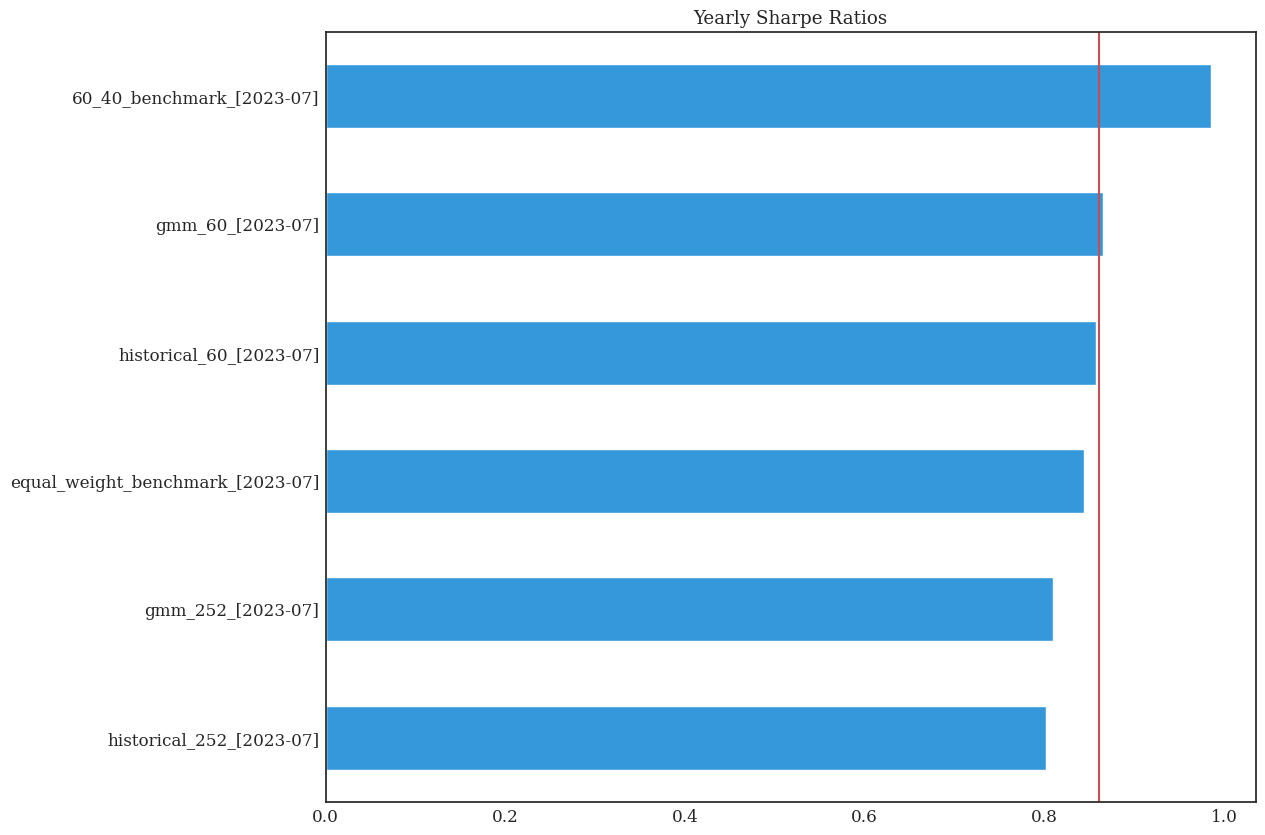

<IPython.core.display.Javascript object>

In [47]:
ax = (
    strat_res.loc["yearly_sharpe"].sort_values().plot.barh(title="Yearly Sharpe Ratios")
)
plt.axvline(strat_res.loc["yearly_sharpe"].mean(), color="r")
#add_watermark(ax, scale=1.25)

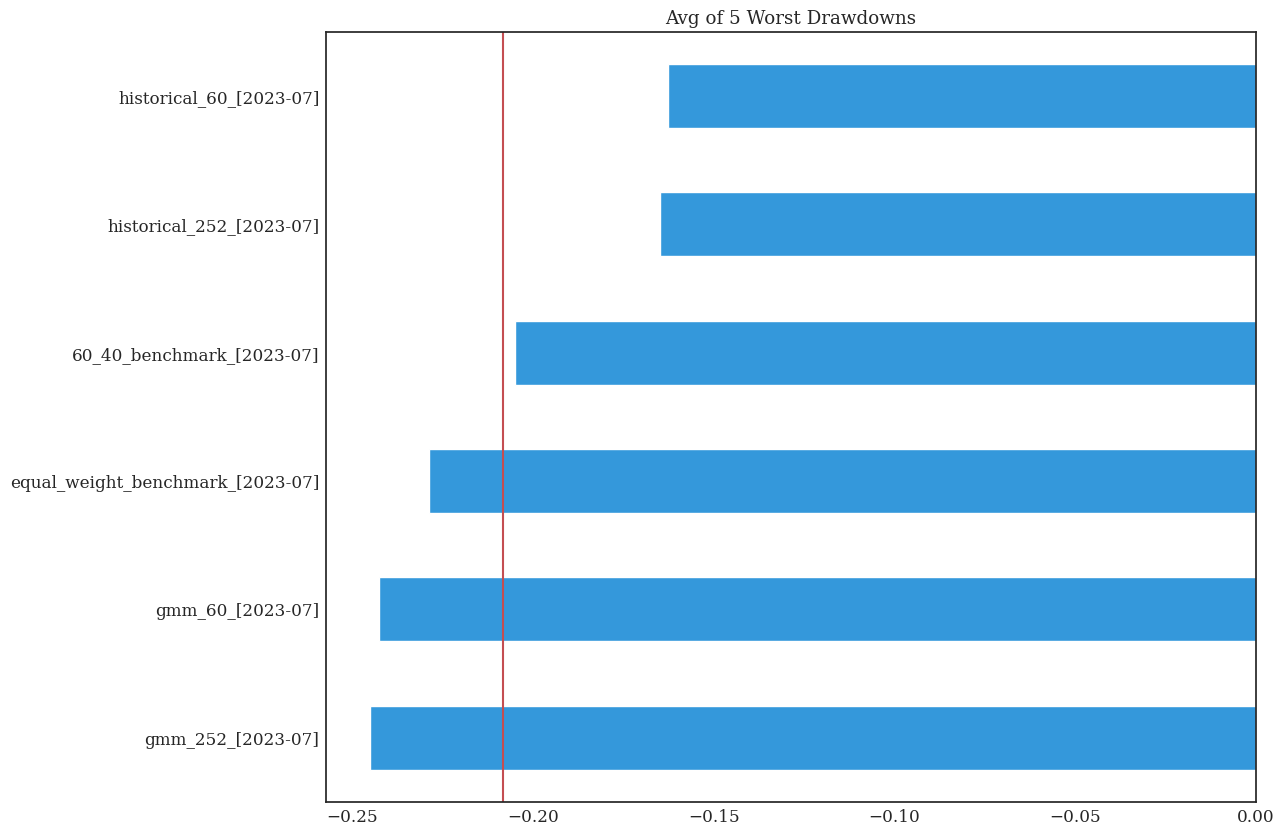

<IPython.core.display.Javascript object>

In [48]:
ax = (
    strat_res.loc["avg_worst_5_drawdowns"]
    .sort_values(ascending=True)
    .plot.barh(title="Avg of 5 Worst Drawdowns")
)
ax.axvline(strat_res.loc["avg_worst_5_drawdowns"].mean(), color="r")
#add_watermark(ax, scale=1.25)

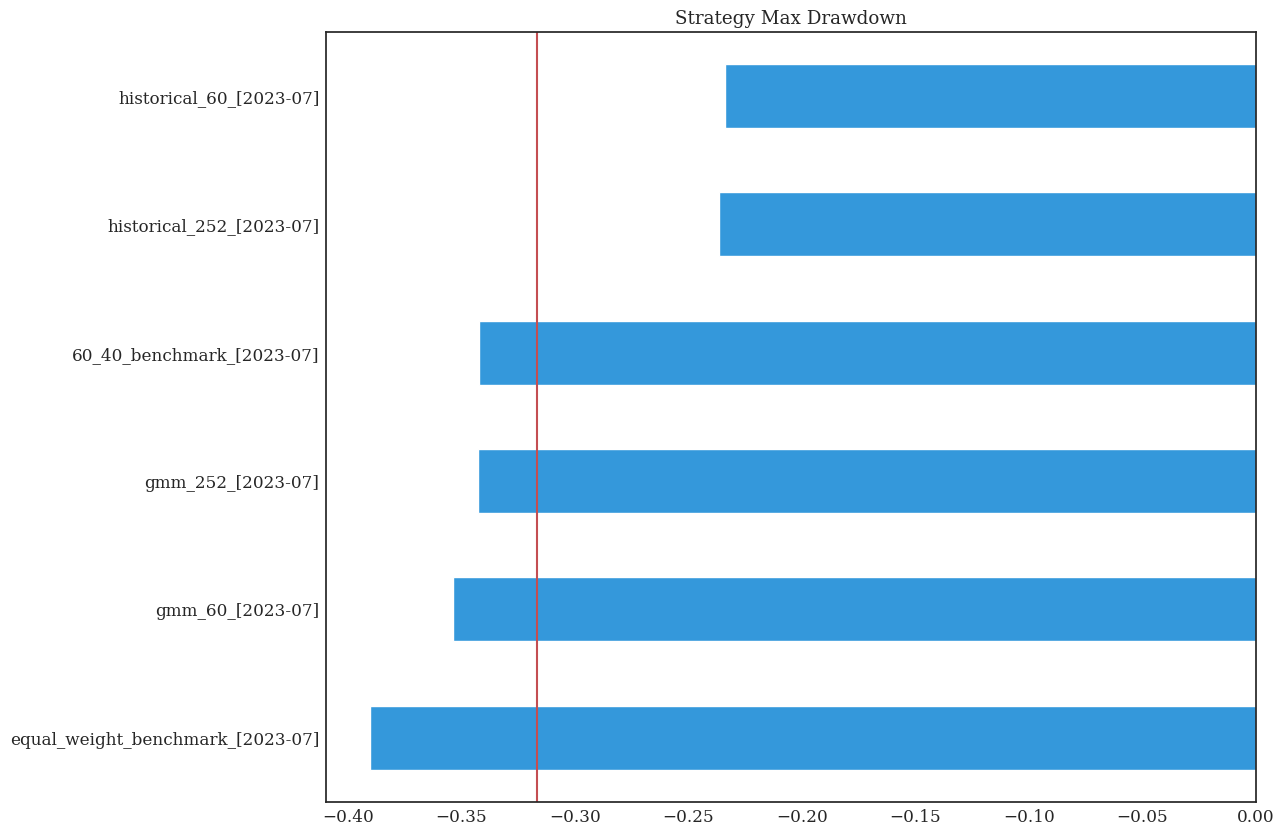

<IPython.core.display.Javascript object>

In [49]:
ax = (
    strat_res.loc["max_drawdown"].sort_values().plot.barh(title="Strategy Max Drawdown")
)
ax.axvline(strat_res.loc["max_drawdown"].mean(), color="r")

In [50]:
def plot_avg_drawdown_grid():
    y = "avg_worst_5_drawdowns"
    x = "avg_worst_5_drawdown_duration"

    g = sns.relplot(x=x, y=y, data=strat_res.T, aspect=3)
    label_point(
        strat_res.T[x],
        strat_res.T[y],
        pd.Series(strat_res.T.index, index=strat_res.T.index),
        plt.gca(),
        va="bottom",
        ha="center",
    )
    plt.suptitle(
        "Avg of 5 Worst Drawdowns vs Drawdown Durations",
        fontsize=14,
        fontweight="demi",
        y=1.05,
    )

    plt.gca().axhline(strat_res.loc["avg_worst_5_drawdowns"].mean(), ls="--")
    plt.gca().axvline(strat_res.loc["avg_worst_5_drawdown_duration"].mean(), ls="--")

<IPython.core.display.Javascript object>

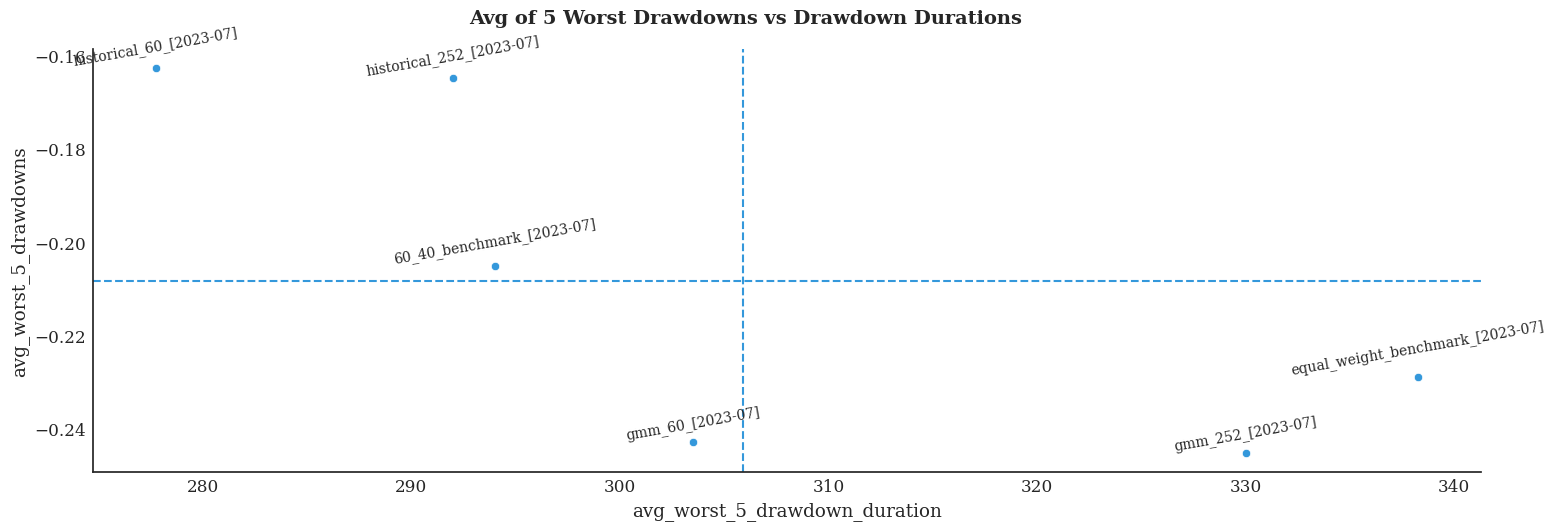

<IPython.core.display.Javascript object>

In [51]:
plot_avg_drawdown_grid()

In [52]:
def plot_csr_by_maxdd():
    x = "common_sense_ratio"
    y = "max_drawdown"
    g = sns.relplot(x=x, y=y, data=strat_res.T, aspect=3)
    label_point(
        strat_res.T[x],
        strat_res.T[y],
        pd.Series(strat_res.T.index, index=strat_res.T.index),
        plt.gca(),
        va="bottom",
        ha="center",
    )
    plt.title("Max Drawdown vs Common Sense Ratio", fontsize=14, fontweight="demi")
    plt.gca().axhline(strat_res.T[y].mean(), ls="--")
    plt.gca().axvline(strat_res.T[x].mean(), ls="--")
    return plt.gcf()

<IPython.core.display.Javascript object>

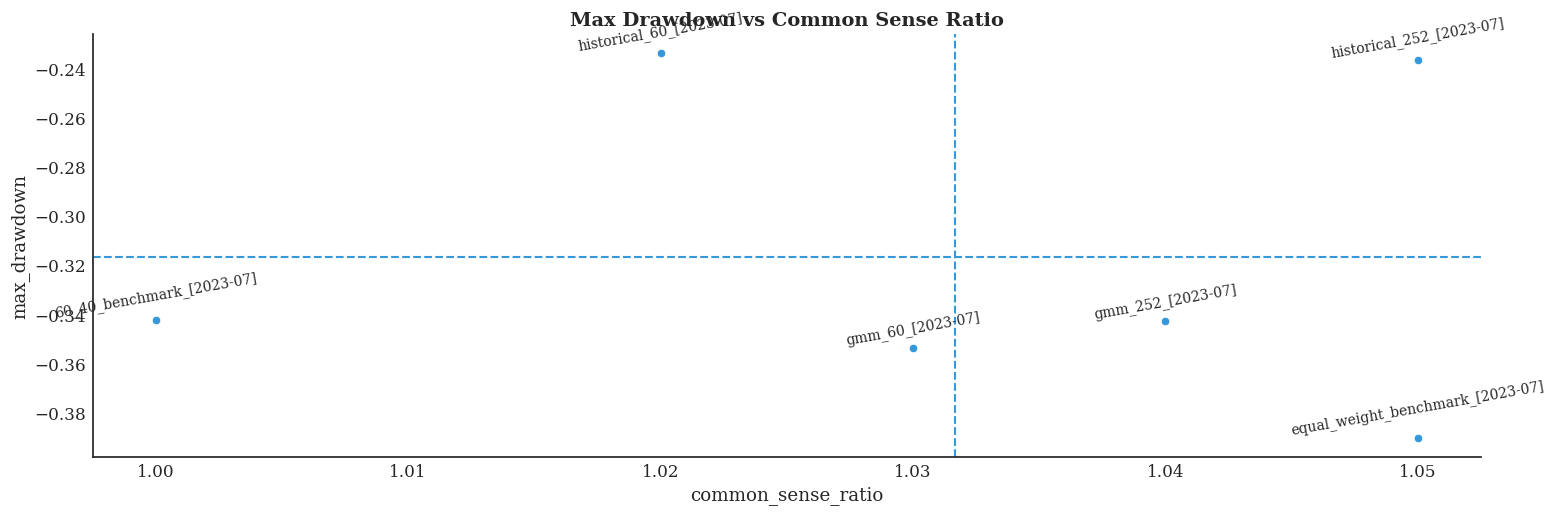

<IPython.core.display.Javascript object>

In [53]:
_ = plot_csr_by_maxdd()

In [54]:
def plot_maxdd_by_sharpe():
    x = "max_drawdown"
    y = "yearly_sharpe"

    g = sns.relplot(x=x, y=y, data=strat_res.T, aspect=3)
    label_point(
        strat_res.T[x],
        strat_res.T[y],
        pd.Series(strat_res.T.index, index=strat_res.T.index),
        plt.gca(),
    )
    plt.title("Max Drawdown vs Yearly Sharpe", fontsize=14, fontweight="demi")
    plt.gca().axhline(strat_res.T[y].mean(), ls="--")
    plt.gca().axvline(strat_res.T[x].mean(), ls="--")
    return plt.gcf()

<IPython.core.display.Javascript object>

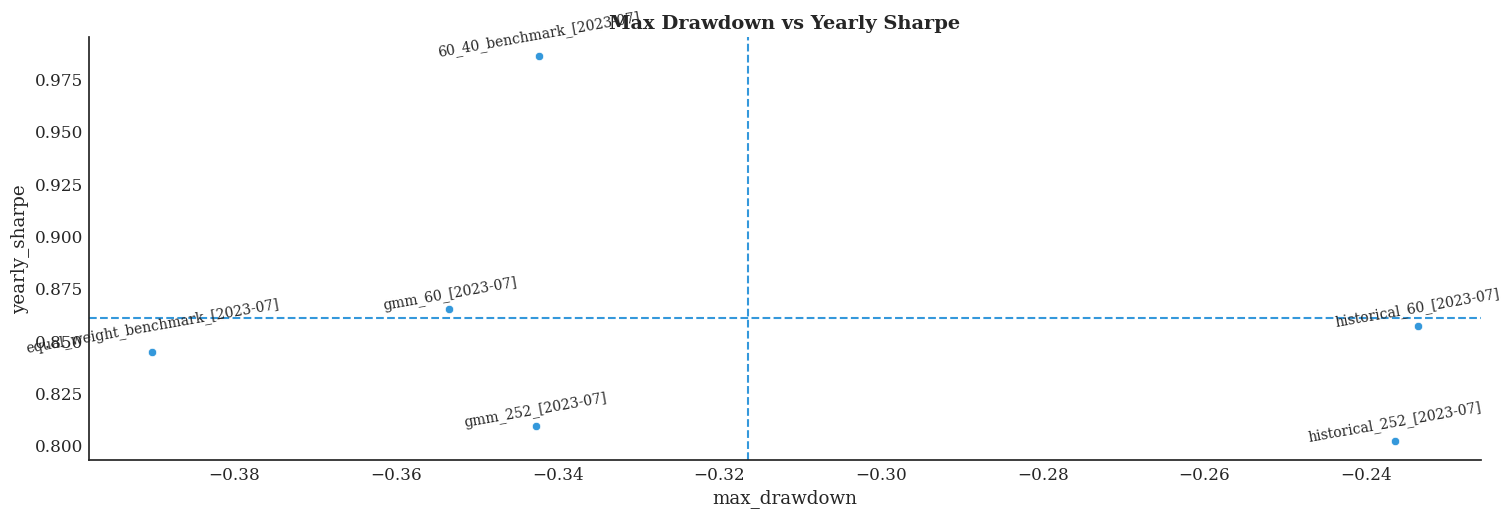

<IPython.core.display.Javascript object>

In [55]:
_ = plot_maxdd_by_sharpe()

In [56]:
perf["gmm_60_[2023-07]"].display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug     Sep     Oct    Nov    Dec     YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  ------  ------  -----  -----  ------
  2008  -2.72   0.76  -0.06   2.02   0.35  -6.45  -0.75  -1.09   -7.12  -15.08   2.77  10.62  -17.42
  2009  -8.98  -4.95   5.48   6.4    4.95  -0.08   5.49   3.92    5.61   -1.35   6.47  -0.05   23.76
  2010  -3.39   2.44   3.9    3.65  -4.84   0.15   3.04   0.62    5.9     2.85  -1.04   3.55   17.54
  2011   1.07   3.65   0.52   5.48  -0.29  -2.01   2.6    1.15   -4.32    6.37  -1.43   0.82   13.92
  2012   4.58   3.05  -0.1    0.81  -4.53   3.48   2.17   0.85    2.24   -1.9    0.87  -0.06   11.71
  2013   2.87  -0.08   1.78   2.33  -1.41  -5.05   3.39  -2.53    3.52    4.97  -0.39   0.7    10.07
  2014  -1.77   4.97  -0.13   1.38   2.79   1.56   0.79   2.07   -3.43    2.13   2.25   0.87   14.06
  2015   2.87   0.58  -0.1    1.09  -1.32  -3.36   1.43  -5.06   -1.95    5.52  -1.66  -0.9

<IPython.core.display.Javascript object>

<Figure size 1200x1000 with 0 Axes>

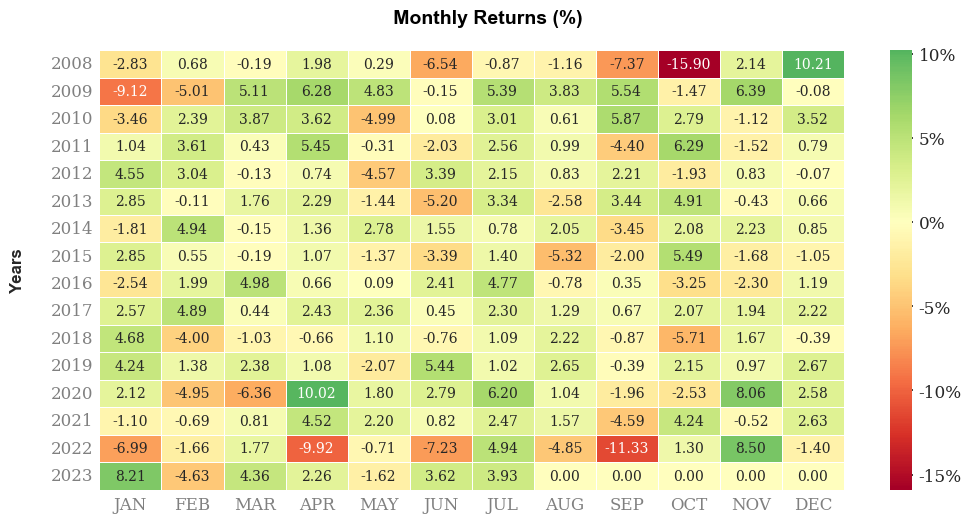

<IPython.core.display.Javascript object>

In [57]:
plt.figure(figsize=(12, 10))
qs.plots.monthly_heatmap(strats["gmm_60_[2023-07]"])

## Conclusions

The `gmm_60` algorithm is the updated winner on a risk-adjusted basis. It had the highest common sense ratio relative to max drawdown. It was also in the left quadrant of the 'Average 5 Worst' chart demonstrating a relatively low average 5 worst drawdown to average 5 worst drawdown duration. 

However as can be seen below the gmm had the highest cagrs followed by the benchmarks.

In [58]:
strat_res.T.cagr.sort_values(ascending=False)

gmm_60_[2023-07]                   0.0883
gmm_252_[2023-07]                  0.0787
60_40_benchmark_[2023-07]          0.0717
equal_weight_benchmark_[2023-07]   0.0689
historical_60_[2023-07]            0.0602
historical_252_[2023-07]           0.0543
Name: cagr, dtype: object

<IPython.core.display.Javascript object>

In [59]:
strat_res.T.sort_values("cagr", ascending=False)

,start,end,rf,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,daily_mean,...,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc,common_sense_ratio,avg_worst_5_drawdown_duration,avg_worst_5_drawdowns
gmm_60_[2023-07],2008-01-01 05:00:00+00:00,2023-07-31 20:00:00+00:00,0.0000,2.7365,0.0883,-0.3534,0.2498,0.6458,1.0200,0.0790,...,-0.2443,-0.0159,20.8306,0.0289,-0.0284,0.8000,0.8182,1.0300,303.5000,-0.2428
gmm_252_[2023-07],2008-01-01 05:00:00+00:00,2023-07-31 20:00:00+00:00,0.0000,2.2527,0.0787,-0.3428,0.2295,0.5840,0.9138,0.0715,...,-0.2433,-0.0161,23.2523,0.0277,-0.0291,0.8000,0.8295,1.0400,330.0000,-0.2452
60_40_benchmark_[2023-07],2008-01-01 05:00:00+00:00,2023-07-31 20:00:00+00:00,0.0000,1.9429,0.0717,-0.3423,0.2096,0.6050,0.9276,0.0642,...,-0.1604,-0.0104,18.3843,0.0215,-0.0267,0.8667,0.8523,1.0000,294.0000,-0.2051
equal_weight_benchmark_[2023-07],2008-01-01 05:00:00+00:00,2023-07-31 20:00:00+00:00,0.0000,1.8235,0.0689,-0.3902,0.1766,0.5174,0.8097,0.0640,...,-0.1839,-0.0154,23.1318,0.0256,-0.0276,0.8000,0.8239,1.0500,338.2500,-0.2289
historical_60_[2023-07],2008-01-01 05:00:00+00:00,2023-07-31 20:00:00+00:00,0.0000,1.4846,0.0602,-0.2336,0.2575,0.6624,1.0465,0.0525,...,-0.1622,-0.0105,20.2177,0.0184,-0.0197,0.8000,0.8239,1.0200,277.7500,-0.1628
historical_252_[2023-07],2008-01-01 05:00:00+00:00,2023-07-31 20:00:00+00:00,0.0000,1.2776,0.0543,-0.2364,0.2295,0.6030,0.9450,0.0478,...,-0.1646,-0.0108,22.4222,0.0179,-0.0195,0.8000,0.8295,1.0500,292.0000,-0.1648


<IPython.core.display.Javascript object>

In [60]:
strat_res.to_csv('../results/strategy_results.csv')

<IPython.core.display.Javascript object>